In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
data_full = pd.read_csv('data/data_full.csv')

df_train['data'] = pd.to_datetime(df_train['data'], format='%Y-%m-%d')
df_test['data'] = pd.to_datetime(df_test['data'], format='%Y-%m-%d')
data_full['data'] = pd.to_datetime(data_full['data'], format='%Y-%m-%d')

In [10]:
df_odds = pd.read_csv('data/historico_odds.csv', encoding='latin-1', sep=';')

for col in ['PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']:
    df_odds[col] = df_odds[col].str.replace(',','.').astype(float) # Substitui , por .

df_odds['Date'] = pd.to_datetime(df_odds['Date'], format='%d/%m/%Y')

In [11]:
# Agrega a informação de Odds
df_train = pd.merge(df_train,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

df_test = pd.merge(df_test,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

data_full = pd.merge(data_full,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

In [12]:
df_train.shape, df_test.shape

((1081, 163), (450, 163))

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [15]:
dropar = ['data',  'estadio', 'arbitro', 'time_man', 'tecnico_man', 'time_vis','tecnico_vis', 
          'vitoria_man', 'vitoria','ano_campeonato','rodada', 'AvgH', 'AvgD', 'AvgA']

X_train = df_train.drop(dropar ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(dropar ,axis=1)
y_test = df_test['vitoria']


In [100]:
# Apesar das variaveis de 'colocacao' serem categoricas ordinais, vamos normalizá-las como numericas.
cat_ord = ['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'] # Categoricas Ordinais por Encoding
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord] 

In [101]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')) # Para variaveis de encoding, imputa mising com a media            
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
            # transformers.append((num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))
            # transformers.append((cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers,
                                         verbose_feature_names_out=False) # Nao adiciona prefixo

        return preprocessor
    else:
        return None

In [102]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['publico', 'publico_max', 'colocacao_man',
                                  'valor_equipe_titular_man',
                                  'idade_media_titular_man',
                                  'flag_jogo_casa_man',
                                  'diff_idade_media_adv_man',
                                  'diff_valor_equipe_adv_man',
                                  'diff_colocacao_adv_man', 'med_publico_3_man',
                                  'med_pu...
                                  'med_perc_faltas_com_6_man',
                                  'med_faltas_sof_3_man',
                                  'med_faltas_sof_6_man',
                                  'med_perc_faltas_sof_3_man',
                                  'med_perc_faltas_sof_6_man',
                                  'med_chutes_com_3_man',
                                  'med_chutes_com_6_man',
                                  'med_perc_chutes_com_3_man', ...]),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['tecnico_man_enc', 'tecnico_vis_enc',
                                  'time_man_enc', 'time_vis_enc'])],
                  verbose_feature_names_out=False)

In [103]:
X_sel_train = preprocessor_1.transform(X_train)
X_sel_test = preprocessor_1.transform(X_test)

In [104]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [105]:
X_sel_train.drop(['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'], axis=1, inplace=True)

In [106]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [107]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

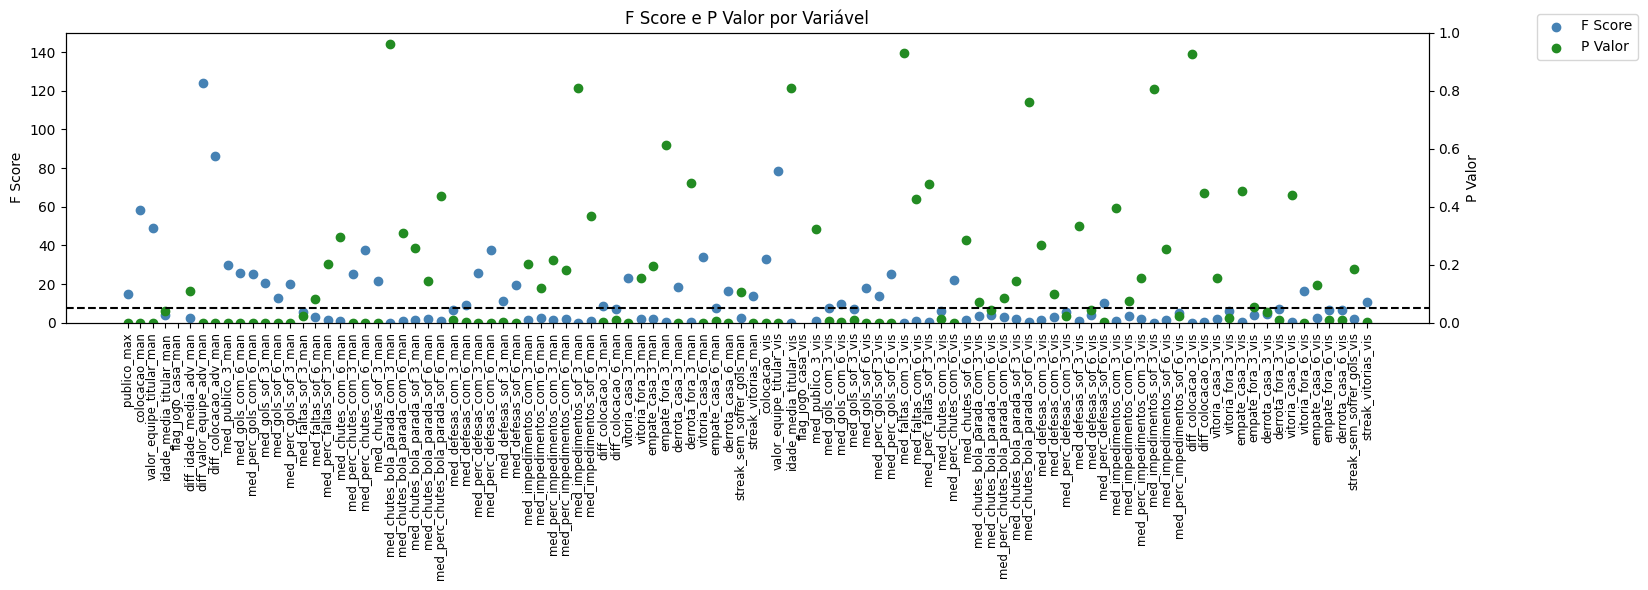

---- Variáveis em Ordem Descrescente de Força ----
diff_valor_equipe_adv_man
diff_colocacao_adv_man
valor_equipe_titular_vis
colocacao_man
valor_equipe_titular_man
med_perc_chutes_com_6_man
med_perc_defesas_com_6_man
vitoria_casa_6_man
colocacao_vis
med_publico_3_man
med_perc_defesas_com_3_man
med_gols_com_6_man
med_perc_chutes_com_3_man
med_perc_gols_sof_6_vis
med_perc_gols_com_6_man
vitoria_casa_3_man
med_perc_chutes_com_6_vis
med_chutes_sof_3_man
med_gols_sof_3_man
med_perc_gols_sof_3_man
med_defesas_sof_6_man
derrota_casa_3_man
med_gols_sof_6_vis
derrota_casa_6_man
vitoria_fora_6_vis
publico_max
med_perc_gols_sof_3_vis
streak_vitorias_man
med_gols_sof_6_man
med_defesas_sof_3_man
streak_vitorias_vis
med_perc_defesas_sof_6_vis
med_gols_com_6_vis
med_defesas_com_6_man
diff_colocacao_3_man
empate_casa_6_man
med_gols_com_3_vis
diff_colocacao_6_man
derrota_fora_3_vis
med_gols_sof_3_vis
derrota_casa_6_vis
med_defesas_com_3_man
empate_fora_6_vis
med_chutes_com_3_vis
vitoria_fora_3_vis
med_

In [108]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(15, 6))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.set_ylim(0,150)
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.10, 0.98))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

In [75]:
len(df_filter)
n_estimators=300, max_depth=2,

1081

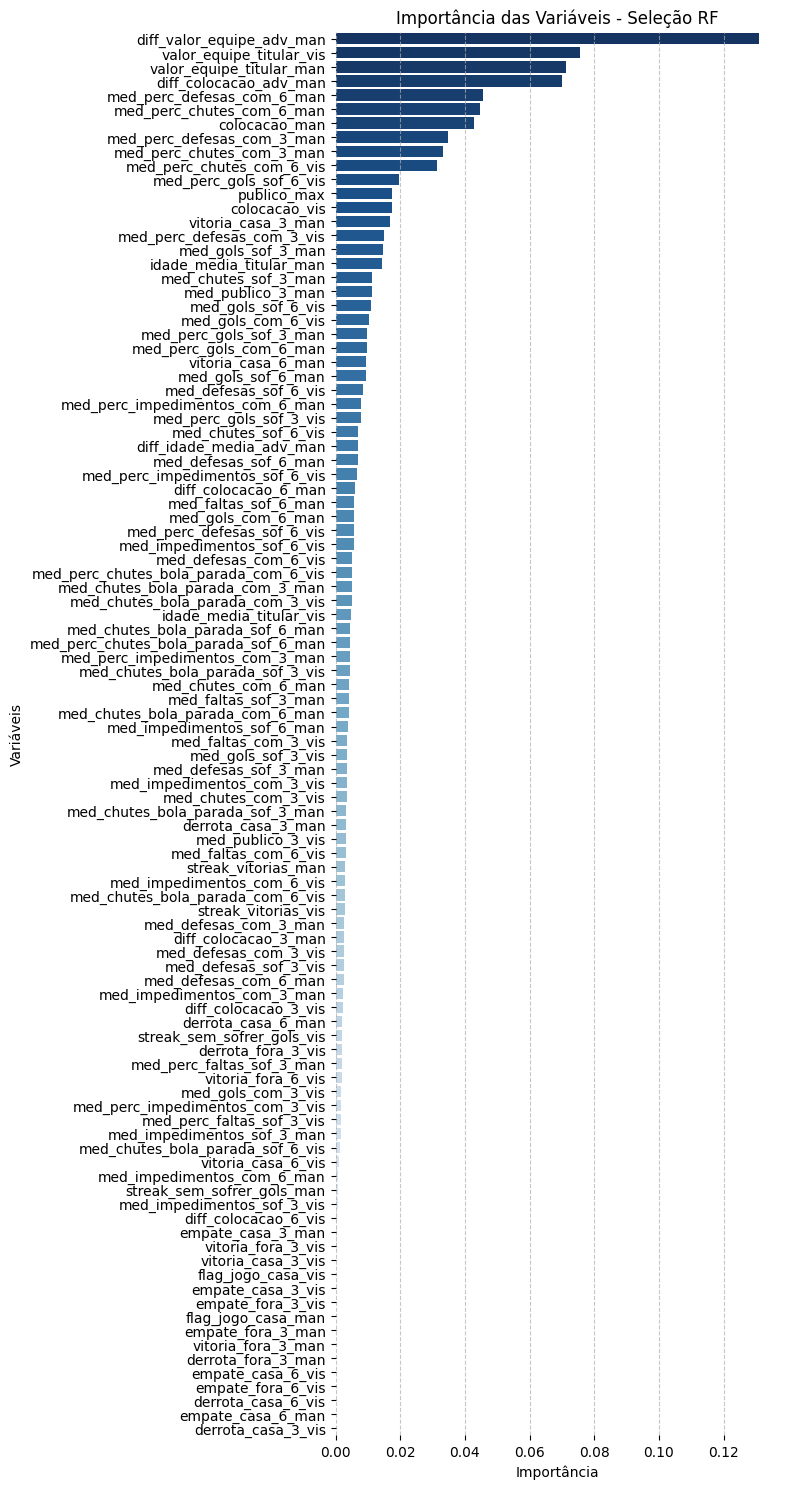

In [109]:
# Crie um modelo de RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42) # Mudar para 3 se possivel

# Treine o modelo
rf_model.fit(df_filter, y_train)

# Obtenha a importância das características
feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(8, 15))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 12 variáveis (med_perc_defesas_com_3 pra cima). Assim, podemos adotar um corte na importancia de 0.03

In [110]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.02, 'RF_SEL'] = 1

In [111]:
feature_importances[feature_importances['RF_SEL']==1].sort_values(by='IMP',ascending=False)

,VAR,IMP,RF_SEL
6,diff_valor_equipe_adv_man,0.130928,1
52,valor_equipe_titular_vis,0.075583,1
2,valor_equipe_titular_man,0.071384,1
7,diff_colocacao_adv_man,0.070045,1
29,med_perc_defesas_com_6_man,0.045763,1
19,med_perc_chutes_com_6_man,0.044682,1
1,colocacao_man,0.042919,1
28,med_perc_defesas_com_3_man,0.034678,1
18,med_perc_chutes_com_3_man,0.033140,1
66,med_perc_chutes_com_6_vis,0.031265,1


Agora, vamos observar como se comporta o AUC Score de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

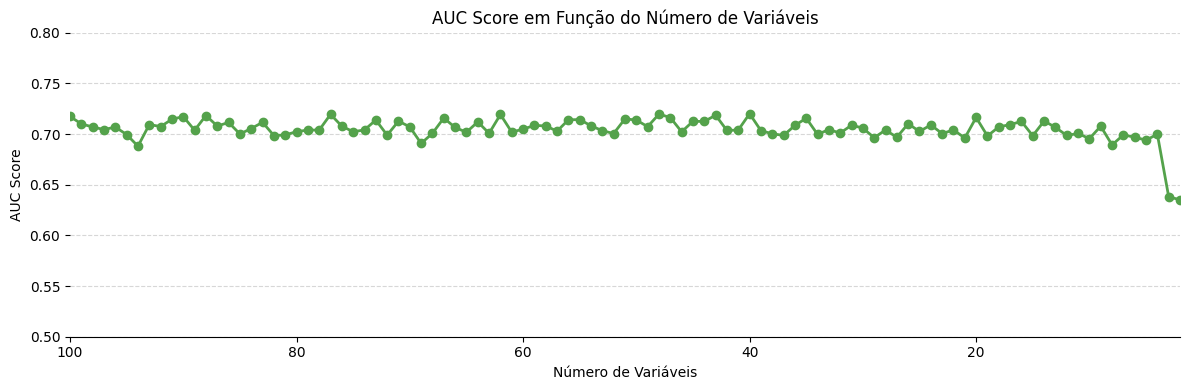

In [112]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
auc_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42) # Mudar para 3 se possivel 
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    y_pred_proba = rf_model.predict_proba(X_sel_test[selected_features_subset])[:,1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    # auc = precision_score(y_test, y_pred) # ACURACIA!
    num_features_list.append(i)
    auc_list.append(auc)

plt.figure(figsize=(12, 4))
plt.plot(num_features_list, auc_list, marker='o', linestyle='-', linewidth=2, color='#54a24b')
plt.xlabel('Número de Variáveis')
plt.ylabel('AUC Score')
plt.title('AUC Score em Função do Número de Variáveis')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
# plt.grid(True)
sns.despine(left=True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0.5, 0.8)

plt.tight_layout()
plt.show()

Nota-se que a partir de 15 variáveis a precisão do Modelo Baseline começa a perder força.

In [113]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')
df_compara_sel.sort_values(by='IMP',ascending=False, inplace=True)
df_compara_sel.head(20)

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
6,diff_valor_equipe_adv_man,124.257913,2.170007e-27,1,0.130928,1
52,valor_equipe_titular_vis,78.747901,2.877336e-18,1,0.075583,1
2,valor_equipe_titular_man,48.804374,4.939639e-12,1,0.071384,1
7,diff_colocacao_adv_man,86.280118,8.348423e-20,1,0.070045,1
29,med_perc_defesas_com_6_man,37.448823,1.311184e-09,1,0.045763,1
19,med_perc_chutes_com_6_man,37.781580,1.111924e-09,1,0.044682,1
1,colocacao_man,58.350752,4.821110e-14,1,0.042919,1
28,med_perc_defesas_com_3_man,25.890737,4.259223e-07,1,0.034678,1
18,med_perc_chutes_com_3_man,25.269577,5.833006e-07,1,0.033140,1
66,med_perc_chutes_com_6_vis,22.252240,2.704285e-06,1,0.031265,1


In [114]:
vars_sel = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas 12 que foram selecionadas por RandomForest

In [115]:
vars_sel

['diff_valor_equipe_adv_man',
 'valor_equipe_titular_vis',
 'valor_equipe_titular_man',
 'diff_colocacao_adv_man',
 'med_perc_defesas_com_6_man',
 'med_perc_chutes_com_6_man',
 'colocacao_man',
 'med_perc_defesas_com_3_man',
 'med_perc_chutes_com_3_man',
 'med_perc_chutes_com_6_vis']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

OBS: As variáveis time_enc e time_adversario_enc foram retiradas de forma a evitar overfitting ou ocasionar um viés em relação ao time vs. time adversário. Assim, manteremos apenas o tecnico como variável encoded.

In [117]:
vars_final = [
    'diff_valor_equipe_adv_man',
    'valor_equipe_titular_vis',
    'valor_equipe_titular_man',
    'diff_colocacao_adv_man',
    'med_perc_defesas_com_6_man',
    'med_perc_chutes_com_6_man',
    'colocacao_man',
    'med_perc_defesas_com_3_man',
    'med_perc_chutes_com_3_man',
    'med_perc_chutes_com_6_vis'
 ]

num_finais = [ 
    'diff_valor_equipe_adv_man',
    'valor_equipe_titular_vis',
    'valor_equipe_titular_man',
    'diff_colocacao_adv_man',
    'med_perc_defesas_com_6_man',
    'med_perc_chutes_com_6_man',
    'colocacao_man',
    'med_perc_defesas_com_3_man',
    'med_perc_chutes_com_3_man',
    'med_perc_chutes_com_6_vis'
 ]

cat_ord_finais = [
 
]



preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
# X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
# X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização. Podemos escolher a precisão, que mede a proporção de todas as previsões corretas que o modelo fez. Além disso, podemos utilizar uma abordagem de retorno para apostas através da métrica ROI (Return Over Investment)

Sendo assim, vamos combinar a precisão e o ROI na nossa métrica de maximização, adotando pesos para ambos.
Em resumo:

-   O ROI mede a lucratividade financeira, indicando diretamente a capacidade do modelo de gerar retornos sobre o investimento.
-   A precisão é ideal para evitar falsos positivos. Com isso, evitariamos perdas financeiras ao apostar na vitoria de um determinado jogo.

Para cada jogo vamos considerar que será apostado $10 e que para cada ganho, tenha um lucro de 10% sobre o valor apostado

In [120]:
def roi_score(y_true, y_pred_proba, stake_per_bet=10):
    '''
    Calcula o retorno sobre o investimento (ROI)
    '''   

    y_pred = (y_pred_proba >= 0.5).astype(int) # Limiar de 0.5

    total_bets = len(y_true)
    total_wins = sum(y_true * y_pred)

    total_payouts = total_wins * stake_per_bet * 1.1  # Considerando 10% de lucro em vitorias
    total_staked = total_bets * stake_per_bet # Total apostado nao considerando lucros
    net_profit = total_payouts - total_staked
    
    return (net_profit / total_staked)

In [121]:
def cost_sensitive_precision(y_true, y_pred, tp_weight=1, fp_weight=5):
    '''
    Calcula a Precisao com pesos aplicados no TP e FP de 
    forma a penalizar falsos positivos.

    Este método é util quando temos classes desbalanceada. No nosso caso, a taxa de vitoria é 30%
    '''    

    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]  
    fp = cm[0, 1] 

    weighted_tp = -tp_weight*tp
    weighted_fp = -fp_weight*fp    

    cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)

    if np.isnan(cost_sensitive_precision):
        return 0
    else:
        return cost_sensitive_precision

In [122]:
def evaluate_calibration(y_true, y_prob, n_bins=5):
    """
    Calculates calibration metrics.

    Args:
        y_true (array-like): True binary outcomes (0 or 1).
        y_prob (array-like): Predicted probabilities of positive class.
        n_bins (int, optional): Number of bins for calibration curve. Defaults to 5.

        Expected Calibration Error (ECE)
    """

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

        # Calculate ECE
    ece = np.abs(prob_true - prob_pred).mean()

    return ece

In [123]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [124]:
len(df_train_f)

1081

In [127]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=900, test_size=200) # Considerando apenas vitoria e derrota, retirando empates.
# tscv = TimeSeriesSplit(n_splits=3, max_train_size=600, test_size=250) # Considerando vitoria, empate e derrota
# tscv = TimeSeriesSplit(n_splits=4)

# metrics_folds = []    
for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

    tam_treino = len(train_index)
    tam_teste = len(test_index)
    total = tam_treino + tam_teste
    print(f'TREINO: {tam_treino}, TESTE: {tam_teste}, SOMA: {total}')
    print('% TREINO', tam_treino/total)
    print('% TESTE', tam_teste/total)
    # print(f'TREINO: {train_index}, TESTE: {test_index}')

TREINO: 481, TESTE: 200, SOMA: 681
% TREINO 0.7063142437591777
% TESTE 0.2936857562408223
TREINO: 681, TESTE: 200, SOMA: 881
% TREINO 0.7729852440408627
% TESTE 0.22701475595913734
TREINO: 881, TESTE: 200, SOMA: 1081
% TREINO 0.8149861239592969
% TESTE 0.18501387604070305


In [128]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [132]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 10, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga',]),
            max_iter=trial.suggest_int('max_iter', 100, 1000),
            # tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 10, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            # gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            gamma=trial.suggest_float('gamma', 1e-3, 10, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )
        
    tscv = TimeSeriesSplit(n_splits=3, max_train_size=900, test_size=200)
    # tscv = TimeSeriesSplit(n_splits=3, max_train_size=800, test_size=150) 
    metrics_folds = []    
    for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

        train = df_train_f.iloc[train_index]
        X_train = train.drop(['vitoria'],axis=1)
        y_train = train['vitoria']

        valid = df_train_f.iloc[test_index]
        X_valid = valid.drop(['vitoria'],axis=1)
        y_valid = valid['vitoria']

        model.fit(X_train, y_train)        
        y_pred_proba = model.predict_proba(X_valid)[:, 1]        
        
        result = log_loss(y_valid, y_pred_proba)
        metrics_folds.append(result)
               
    return np.mean(metrics_folds)  

In [134]:
# models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']
models = ['RandomForest', 'LogisticRegression', 'LGBM', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    print(f'Melhores parametros: {best_params}')
    best_value = round(study.best_value,4)
    print(f'Melhor valor  {best_value}')

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

------ RandomForest ------


Melhores parametros: {'n_estimators': 426, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 91, 'min_samples_leaf': 13, 'bootstrap': True}
Melhor valor  0.6028
------ LogisticRegression ------
Melhores parametros: {'C': 0.43473303521590245, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 363}
Melhor valor  0.5959
------ LGBM ------
Melhores parametros: {'n_estimators': 389, 'max_depth': 4, 'learning_rate': 0.006228167347378267, 'num_leaves': 116, 'min_data_in_leaf': 113, 'bagging_fraction': 0.05453446359752144, 'reg_alpha': 0.07585221717944357, 'reg_lambda': 0.002533236599064037}
Melhor valor  0.6093
------ SVC ------
Melhores parametros: {'C': 0.8691847887180779, 'kernel': 'linear', 'gamma': 4.893631722558204, 'shrinking': True, 'probability': True}
Melhor valor  0.6123
------ DecisionTree ------
Melhores parametros: {'max_depth': 1, 'min_samples_split': 10, 'max_leaf_nodes': 27, 'criterion': 'entropy'}
Melhor valor  0.6316


In [135]:
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.43473303521590245, 'penalty': 'l2', 's...",0.5959
0,RandomForest,"{'n_estimators': 426, 'max_depth': 3, 'criteri...",0.6028
2,LGBM,"{'n_estimators': 389, 'max_depth': 4, 'learnin...",0.6093
3,SVC,"{'C': 0.8691847887180779, 'kernel': 'linear', ...",0.6123
4,DecisionTree,"{'max_depth': 1, 'min_samples_split': 10, 'max...",0.6316


In [136]:
comparison_df.iloc[1].values

array(['LogisticRegression',
       {'C': 0.43473303521590245, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 363},
       0.5959], dtype=object)

O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi a Regressão Logistica. Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [378]:
# Com LOG LOSS
# model_f = SVC(C=0.11414081613170533,
#               kernel='linear',
#               gamma=0.01827618492117167,
#               shrinking=False,
#               probability=True,
#               random_state=42)

# Com LOG LOSS RETIRANDO EMPATES!
# model_f = SVC(C=1.475971398298254,
#               kernel='linear',
#               gamma=2.8357455238209974,
#               shrinking=False,
#               probability=True,
#               random_state=42)

# COM MULTICLASS
# model_f = LogisticRegression(C=0.8486938535821579,
#               penalty='l2',
#               solver='lbfgs',
#               max_iter=403,
#               tol= 0.0007212499622044792,
#               random_state=42)

# LDA
# model_f=LinearDiscriminantAnalysis(solver='lsqr')

# Com AUC SCORE
model_f = LogisticRegression(C=0.43473303521590245,
              penalty='l2',
              solver='saga',
              max_iter=400,
              random_state=42)


model_f.fit(X_train_f, y_train)
pred_train = model_f.predict(X_train_f)
pred_proba_train = model_f.predict_proba(X_train_f)[:,1]
# pred_proba_train = model_f.predict_proba(X_train_f)
pred_f = model_f.predict(X_test_f)
pred_proba_test = model_f.predict_proba(X_test_f)[:,1]
# pred_proba_test = model_f.predict_proba(X_test_f)

# print(A)

print('--- TREINO ---')
print(f'ROI: {roi_score(y_train, pred_train)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_train, pred_train)}')
# print(f'Precisao: {precision_score(y_train, pred_train)}')
print(f'''ROC: {roc_auc_score(y_train, pred_proba_train)}''')
print(f'Acuracia: {accuracy_score(y_train, pred_train)}')

print('--- TESTE ---')
print(f'ROI: {roi_score(y_test, pred_f)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_test, pred_f)}')
# print(f'Precisao: {precision_score(y_test, pred_f)}')
print(f'''ROC: {roc_auc_score(y_test, pred_proba_test)}''')
print(f'Acuracia: {accuracy_score(y_test, pred_f)}')

--- TREINO ---
ROI: -0.3283996299722478
Precisao Penalizada: 0.35294117647058826
ROC: 0.7263844780824775
Acuracia: 0.7178538390379279
--- TESTE ---
ROI: -0.3497777777777777
Precisao Penalizada: 0.2952275249722531
ROC: 0.7262920006822446
Acuracia: 0.6733333333333333


In [436]:
df_mod = data_full[data_full['ano_campeonato']>=2018][vars_final+['vitoria_man', 'AvgH',	'AvgD'	,'AvgA', 'ano_campeonato']]
df_mod[vars_final] = preprocessor_final.transform(df_mod[vars_final])

df_train_f = df_mod[(df_mod['ano_campeonato']>=2018) & (df_mod['ano_campeonato']<2022)]
df_test_f = df_mod[(df_mod['ano_campeonato']>=2022)]

In [437]:
df_test_f['pred_vitoria'] = model_f.predict_proba(df_test_f[vars_final])[:, 1]
df_test_f['pred_derrota'] = model_f.predict_proba(df_test_f[vars_final])[:, 0] 
df_test_f['prob_impl_vitoria'] = 1 / df_test_f['AvgH']
df_test_f['prob_impl_derrota'] = 1 / df_test_f['AvgA']

df_train_f['pred_vitoria'] = model_f.predict_proba(df_train_f[vars_final])[:, 1]
df_train_f['pred_derrota'] = model_f.predict_proba(df_train_f[vars_final])[:, 0] 
df_train_f['prob_impl_vitoria'] = 1 / df_train_f['AvgH']
df_train_f['prob_impl_derrota'] = 1 / df_train_f['AvgA']

Distribuição da probabilidade do Modelo para vitoria do time mandante agrupado pelo resultado.

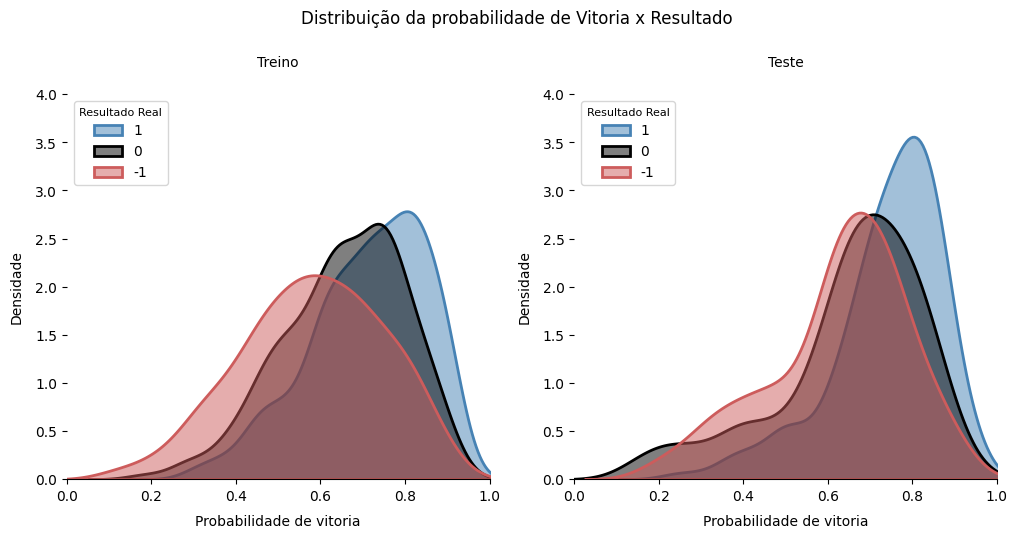

Treino


pred_vitoria                                                   \
                   count     mean       std       min       25%       50%   
vitoria_man                                                                 
-1.0               358.0  0.57994  0.169405  0.102062  0.466757  0.581903   
 0.0               424.0  0.65448  0.143924  0.178588  0.560116  0.665572   
 1.0               723.0  0.71284  0.138674  0.280430  0.624480  0.730230   

                                 
                  75%       max  
vitoria_man                      
-1.0         0.711335  0.920882  
 0.0         0.763475  0.923406  
 1.0         0.820373  0.949819

Teste


pred_vitoria                                                    \
                   count      mean       std       min       25%       50%   
vitoria_man                                                                  
-1.0               164.0  0.625519  0.160550  0.198885  0.539208  0.650676   
 0.0               176.0  0.651896  0.171897  0.147579  0.586746  0.686144   
 1.0               286.0  0.740495  0.130408  0.237934  0.682080  0.766060   

                                 
                  75%       max  
vitoria_man                      
-1.0         0.733872  0.909899  
 0.0         0.772657  0.933322  
 1.0         0.834291  0.956469

In [452]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

sns.kdeplot(df_train_f, 
            x='pred_vitoria', 
            hue='vitoria_man', 
            ax=axs[0],
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','black', 'steelblue']
            )

axs[0].set_xlabel('Probabilidade de vitoria', labelpad=8)
axs[0].set_ylabel('Densidade', labelpad=8)
axs[0].set_title('Treino', fontsize=10, pad=20)
axs[0].legend(title='Resultado Real', labels=['1','0','-1'], title_fontsize=8, loc='upper left')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 4)
sns.despine(ax=axs[0], left=True)    

sns.kdeplot(df_test_f, 
            x='pred_vitoria', 
            hue='vitoria_man', 
            ax=axs[1],
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','black', 'steelblue']
            )

axs[1].set_xlabel('Probabilidade de vitoria', labelpad=8)
axs[1].set_ylabel('Densidade', labelpad=8)
axs[1].set_title('Teste', fontsize=10, pad=20)
axs[1].legend(title='Resultado Real', labels=['1','0','-1'], title_fontsize=8, loc='upper left')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 4)
sns.despine(ax=axs[1], left=True)               

plt.suptitle('Distribuição da probabilidade de Vitoria x Resultado', fontsize=12, y=1.05)
plt.show()

print('Treino')
display(df_train_f.groupby('vitoria_man')[['pred_vitoria']].describe())

print('Teste')
display(df_test_f.groupby('vitoria_man')[['pred_vitoria']].describe())

### Teste de Rentabilidade em apostas esportivas com o uso do Modelo

- Vamos simular apostas para os jogos no conjunto de teste, de forma a avaliar a rentabilidade.
- As apostas serão feitas utilizando o Critério de Kelly: uma abordagem estatística que leva em consideração os Odds, a probabilidade do Modelo e o Saldo.
- Vamos utilizar frações de Kelly para essas apostas (constante K), que tem por objetivo reduzir em K o valor apostado com o intuito de realizar apostas menos arrojadas.
- O Saldo de início será de R$ 1000,00

In [382]:
def kelly_criterion_fraction(probability, odds, fraction=1.0):
    """
    Calcula a fração do Critério de Kelly para o dimensionamento ideal da aposta.

    Parâmetros:
    - odds: Odds decimais (por exemplo, 2.0 para odds iguais, 3.0 para odds de 2:1, etc.).
    - probabilidade: Probabilidade de vitória (deve estar entre 0 e 1).
    - fração: Fração do bankroll atual a considerar (padrão é 1.0).

    Retorna:
    - A fração do bankroll atual a apostar de acordo com o Critério de Kelly.
    """
    b = odds - 1  # Net odds received on the bet
    q = 1 - probability
    kelly = (b * probability - q) / b

    # Ensure the fraction is within the specified limits
    kelly_fraction = fraction*kelly

    return kelly_fraction

In [421]:
# Armazena em arrays
preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = df_test_f['pred_derrota'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values
y_true = df_test_f['vitoria_man'].values

#### Primeira Simulação:

Apostas somente na  vitoria do time mandante:
- O tamanho da aposta será calculado pelo Critério de Kelly, utilizando Odds da vitoria.
- Não considera comparação da probabilidade do modelo x probabilidade implicita.

Lucro total (k = 1): -999.9999999999983
Lucro total (k = 0.5): -999.9999565683029
Lucro total (k = 0.25): -985.957181358056
Lucro total (k = 0.125): -662.7681831720879


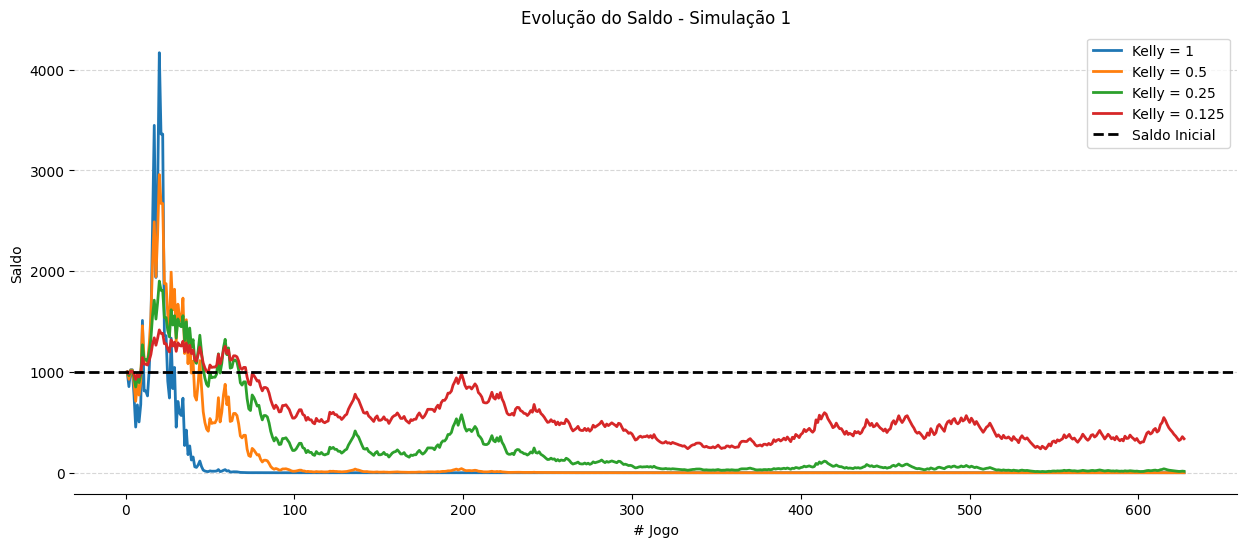

,valor_total_apostado,%_jogos_apostados,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi
0,17227.38,94.74,2001.76,46.3,1385.21,1.000,0.00,-100.00
1,15366.94,94.74,795.71,46.3,589.54,0.500,0.00,-100.00
2,14443.88,94.74,269.47,46.3,297.46,0.250,14.04,-98.60
3,16923.43,94.74,105.24,46.3,151.66,0.125,337.23,-66.28


In [546]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas = [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll
        
        if stake_w < 0:            
            stake = 0 # Nao realiza aposta  
            flag_aposta = 0 
        else:
            stake = stake_w
            flag_aposta = 1
        
        # stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta

        if outcome == 1 and stake_w > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value           
        
        else:
            aposta_ganha = 0
            lucros.append(-stake)   

        bankroll = np.max([0,bankroll])
       
        apostas.append(flag_aposta)
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 1')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação 1:
-   Apostar apenas na vitoria trouxe retornos negativos em todas as frações de Kelly (K)
-   Aproximadamente 95% dos jogos foram apostados, sendo que 46% destes foram em apostas ganhas.
-   Apesar dos resultados negativos, aquele com K = 0.125 resultou no menor prejuízo (ROI de -66,3%)

#### Segunda Simulação:

Apostas na vitoria ou derrota do time mandante:
- O tamanho da aposta será calculado pelo Critério de Kelly, utilizando Odds da vitoria ou derrota do time mandante.
- Não considera comparação da probabilidade do modelo x probabilidade implicita.
- Será realizada apenas uma aposta por jogo (ou na derrota ou vitoria) e não simultaneamente.
- A aposta será no time cujo valor de Kelly for maior (melhor recomendação de acordo com a Probabilidade e Odds).

Lucro total (k = 1): -999.9999999999995
Lucro total (k = 0.5): -999.9999991188381
Lucro total (k = 0.25): -996.479726006054
Lucro total (k = 0.125): -805.3567920813526


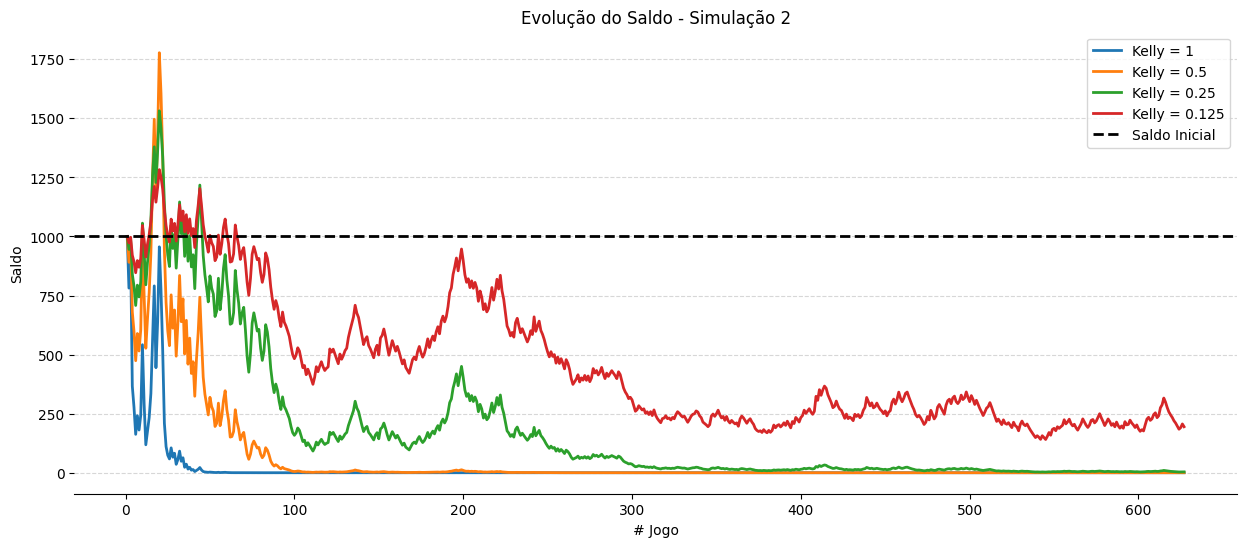

,valor_total_apostado,%_jogos_apostados,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi
0,5071.15,99.84,568.17,45.85,317.74,1.000,0.00,-100.00
1,9529.74,99.84,411.91,45.85,370.13,0.500,0.00,-100.00
2,12342.75,99.84,199.19,45.85,247.47,0.250,3.52,-99.65
3,15405.45,99.84,89.36,45.85,138.83,0.125,194.64,-80.54


In [577]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas = [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll if f_star_w > 0 else 0

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
        stake_l = f_star_l*bankroll if f_star_l > 0 else 0
        
        if stake_w > stake_l:
            flag_aposta = 1
            stake = stake_w
            stake_l = 0            
        elif stake_l > stake_w:
            flag_aposta = 1
            stake = stake_l
            stake_w = 0            
        else:              
            flag_aposta = 0
            stake_w = 0
            stake_l = 0
            stake = 0 
        
        # stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta        

        if outcome == 1 and stake_w > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value    

        elif outcome == -1 and stake_l > 0:
            aposta_ganha = 1
            win_value = stake * (odds_l - 1)
            lucros.append(win_value)
            bankroll += stake + win_value   
                 
        else:
            aposta_ganha = 0
            lucros.append(-stake)   

        bankroll = np.max([0,bankroll])
       
        apostas.append(flag_aposta)
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')    
    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 2')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação 2:
-   Os cenários testados também trouxeram retornos negativos.
-   Aproximadamente 100% dos jogos foram apostados, sendo que 46% destes foram em apostas ganhas.
-   A fração de Kelly de K = 0.125 novamente se mostrou menos prejudicial.

#### Estratégias:

Em vista a buscar melhores resultados, vamos realizar uma comparação da probabilidade do Modelo com a probabilidade implicita (através dos Odds). 

Além disso, vamos estabelecer novas regras baseada nesses dados para realizar novas estratégias.

Relação entre probabilidade do Modelo para vitoria do time mandante ou visitante em comparação com a probabilidade implicita dos Odds

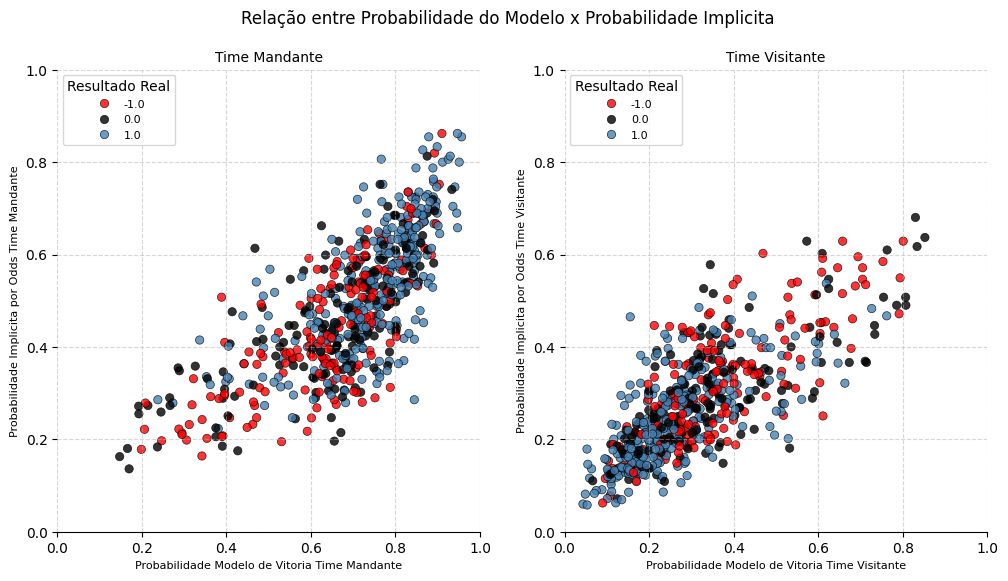

In [493]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# G1
sns.scatterplot(data=df_test_f, 
                x='pred_vitoria', 
                y='prob_impl_vitoria',
                hue='vitoria_man', 
                ax=axs[0],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])

axs[0].set_xlabel('Probabilidade Modelo de Vitoria Time Mandante', fontsize=8)
axs[0].set_ylabel('Probabilidade Implicita por Odds Time Mandante', fontsize=8)
axs[0].set_title('Time Mandante', fontsize=10)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[0].legend(title='Resultado Real', loc='upper left', fontsize=8)

# G2
sns.scatterplot(data=df_test_f, 
                x='pred_derrota', 
                y='prob_impl_derrota',
                hue='vitoria_man', 
                ax=axs[1],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])

axs[1].set_xlabel('Probabilidade Modelo de Vitoria Time Visitante', fontsize=8)
axs[1].set_ylabel('Probabilidade Implicita por Odds Time Visitante', fontsize=8)
axs[1].set_title('Time Visitante', fontsize=10)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[1].legend(title='Resultado Real', loc='upper left', fontsize=8)

fig.suptitle('Relação entre Probabilidade do Modelo x Probabilidade Implicita', fontsize=12)

sns.despine(left=True)

plt.show()

Ao analisar as relações entre as probabilidades, podemos concluir que:

1. Vitoria Mandante:
    -   Para time mandante, uma Prob. Modelo >= 0.8 conseguiria segmentar bem os casos de **vitoria mandante** (resultado = 1.0 - plotagem à esquerda).
    -   Em contrapartida, para o time visitante, uma Prob. Modelo <= 0.25 e Prob. Implicita <= 0.3 separa bem os casos de **vitoria mandante** (resultado = 1.0 - plotagem à direita).

2. Vitoria Visitante:
    -   Para time mandante, uma Prob. Modelo <= 0.7 e Prob. Implicita <= 0.4 segmenta os casos de **vitoria visitante**. No entanto, essa segmentação não é tão efetiva quanto segmentar vitorias mandantes.
    -   Para time visitante, uma Prob. Modelo > 0.55 e Prob. Implicita > 0.4 segmentaria razoavelmente bem os casos de **vitoria visitante**.

Para encontrarmos os melhores cortes possíveis, podemos criar uma Árvore de Decisão com profundidade baixa. Para isso vamos criar mais duas variáveis que seriam a diferença entre a probabilidade do nosso modelo em relação à probabilidade implicita em odds.

In [554]:
df_test_f['diff_prob_vitoria'] = df_test_f['pred_vitoria'] - df_test_f['prob_impl_vitoria']
df_test_f['diff_prob_derrota'] = df_test_f['pred_derrota'] - df_test_f['prob_impl_derrota']

df_train_f['diff_prob_vitoria'] = df_train_f['pred_vitoria'] - df_train_f['prob_impl_vitoria']
df_train_f['diff_prob_derrota'] = df_train_f['pred_derrota'] - df_train_f['prob_impl_derrota']

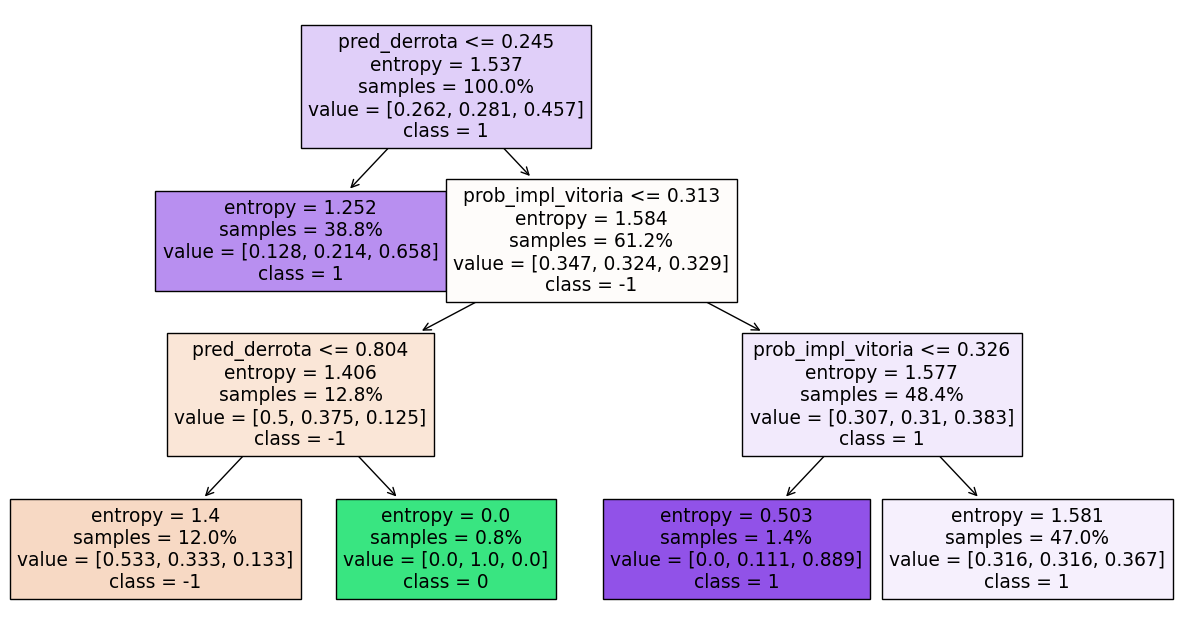

In [538]:
from sklearn import tree

X = df_test_f[['pred_vitoria', 'prob_impl_vitoria', 'pred_derrota', 'prob_impl_derrota', 'diff_prob_vitoria', 'diff_prob_derrota']]
y = df_test_f['vitoria_man']

treemodel = DecisionTreeClassifier(criterion='entropy', max_depth=3, ccp_alpha=0.01, random_state=0)
treemodel.fit(X, y)

plt.figure(figsize=(15, 8)) 
tree.plot_tree(treemodel, filled=True, feature_names=X.columns, proportion=True, class_names=['-1','0','1'])
plt.show()

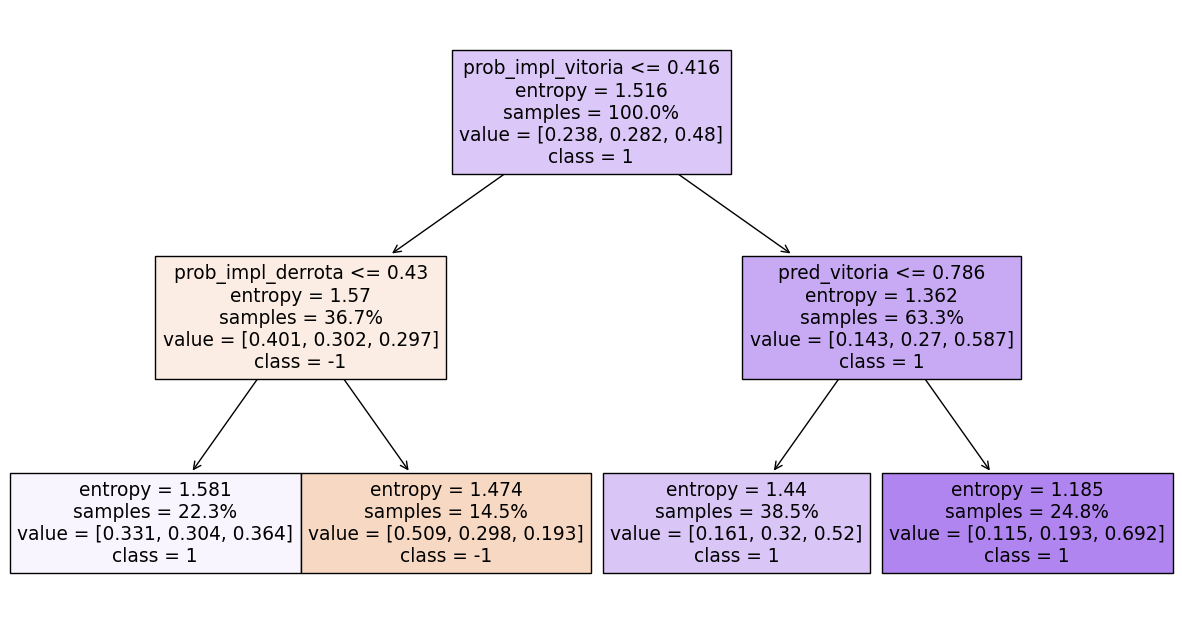

In [560]:
from sklearn import tree

X = df_train_f[['pred_vitoria', 'prob_impl_vitoria', 'pred_derrota', 'prob_impl_derrota', 'diff_prob_vitoria', 'diff_prob_derrota']]
y = df_train_f['vitoria_man']

treemodel = DecisionTreeClassifier(criterion='entropy', max_depth=2, ccp_alpha=0.001, random_state=0)
treemodel.fit(X, y)

plt.figure(figsize=(15, 8)) 
tree.plot_tree(treemodel, filled=True, feature_names=X.columns, proportion=True, class_names=['-1','0','1'])
plt.show()

In [539]:
rules = tree.export_text(treemodel, feature_names=['pred_vitoria', 'prob_impl_vitoria', 'pred_derrota', 'prob_impl_derrota', 'diff_prob_vitoria', 'diff_prob_derrota'])
print(rules)

|--- pred_derrota <= 0.25
|   |--- class: 1.0
|--- pred_derrota >  0.25
|   |--- prob_impl_vitoria <= 0.31
|   |   |--- pred_derrota <= 0.80
|   |   |   |--- class: -1.0
|   |   |--- pred_derrota >  0.80
|   |   |   |--- class: 0.0
|   |--- prob_impl_vitoria >  0.31
|   |   |--- prob_impl_vitoria <= 0.33
|   |   |   |--- class: 1.0
|   |   |--- prob_impl_vitoria >  0.33
|   |   |   |--- class: 1.0



A Árvore encontrou os melhores cortes nas variáveis de probabilidade de derrota e probabilidade implicita de vitória do time mandante. Além disso, analisando a concentração em volume e classes diante das folhas da árvore, podemos adotar uma estratégia também baseada em valores das apostas. Por exemplo, uma folha em que a classe foi bem separada, podemos apostar de acordo com o critério de Kelly (valor da aposta) enquanto que uma folha em que há não há separação de pelo menos 50% da classe, podemos apostar de maneira mais conservadora (com um teto de R$ 200,00). Em folhas com mesma proporção de classes, podemos optar por não realizar apostas.

#### Terceira Simulação:

Apostas na vitoria ou derrota do time mandante:

- O tamanho da aposta será calculado pelo Critério de Kelly se:
    -   pred_derrota <= 0.25 (vitoria mandante)
    -   pred_derrota >  0.25 e prob_impl_vitoria > 0.31 e prob_impl_vitoria <= 0.33 (vitoria mandante)

- A aposta terá um teto de R$ 200,00 se:
    -   pred_derrota >  0.25 e prob_impl_vitoria <= 0.31 (vitoria visitante)

-  Nao será realizada apostas se:
    -   pred_derrota >  0.25 e prob_impl_vitoria >  0.31 e prob_impl_vitoria >  0.33 (proporções iguais)

In [581]:
preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = df_test_f['pred_derrota'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values
y_true = df_test_f['vitoria_man'].values

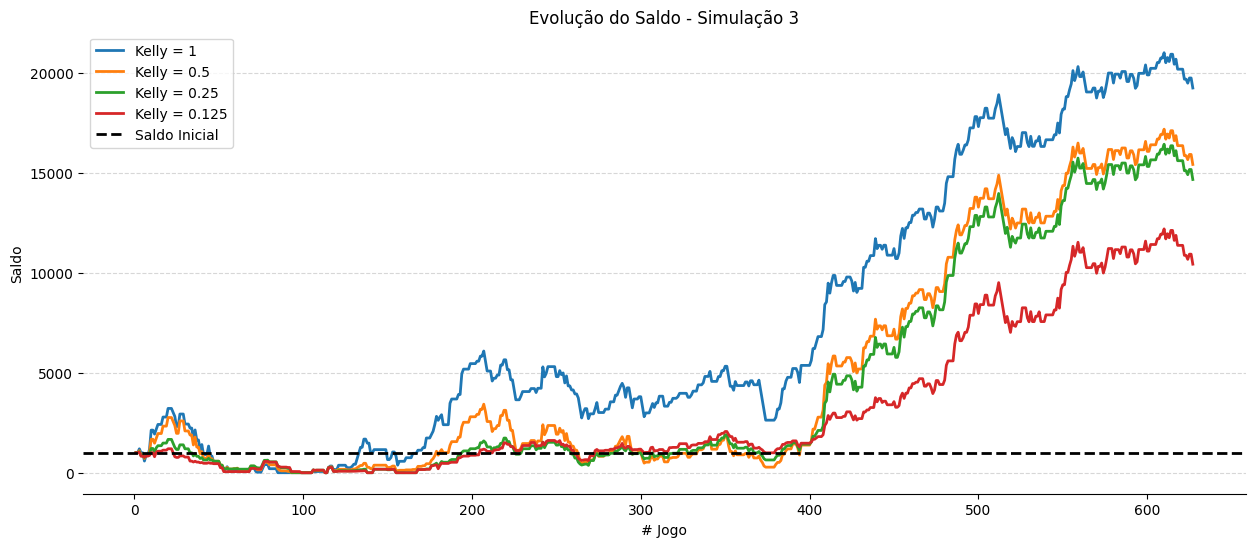

,valor_total_apostado,%_jogos_apostados,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi
0,131491.65,54.07,500.0,59.88,1250.00,1.000,19231.89,1823.19
1,108570.59,54.07,500.0,59.88,1250.00,0.500,15409.64,1440.96
2,87259.66,54.07,500.0,59.00,1138.67,0.250,14657.09,1365.71
3,68747.65,54.07,500.0,59.00,935.00,0.125,10425.11,942.51


In [582]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas = [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll if f_star_w > 0 else 0

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
        stake_l = f_star_l*bankroll if f_star_l > 0 else 0

        if prob_l <= 0.25:
            stake_w = np.min([stake_w,500])
            stake = stake_w
            stake_l = 0
            flag_aposta = 1
        elif prob_l > 0.25 and (1/odds_w) <= 0.31:
            stake_w = 0
            stake_l = 200
            stake = stake_l
            flag_aposta = 1
        elif prob_l > 0.25 and 0.31 < (1/odds_w) <= 0.33:
            stake_w = np.min([stake_w,500])
            stake = stake_w
            stake_l = 0
            flag_aposta = 1
        else:
            stake_w = 0
            stake_l = 0
            stake = 0 
            flag_aposta = 0
                    
        # stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta        

        if outcome == 1 and stake_w > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value    

        elif outcome == -1 and stake_l > 0:
            aposta_ganha = 1
            win_value = stake * (odds_l - 1)
            lucros.append(win_value)
            bankroll += stake + win_value   
                 
        else:
            aposta_ganha = 0
            lucros.append(-stake)   

        bankroll = np.max([0,bankroll])
       
        stakes.append(stake)        
        apostas.append(flag_aposta)
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll) 

    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)    
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)   

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 3')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

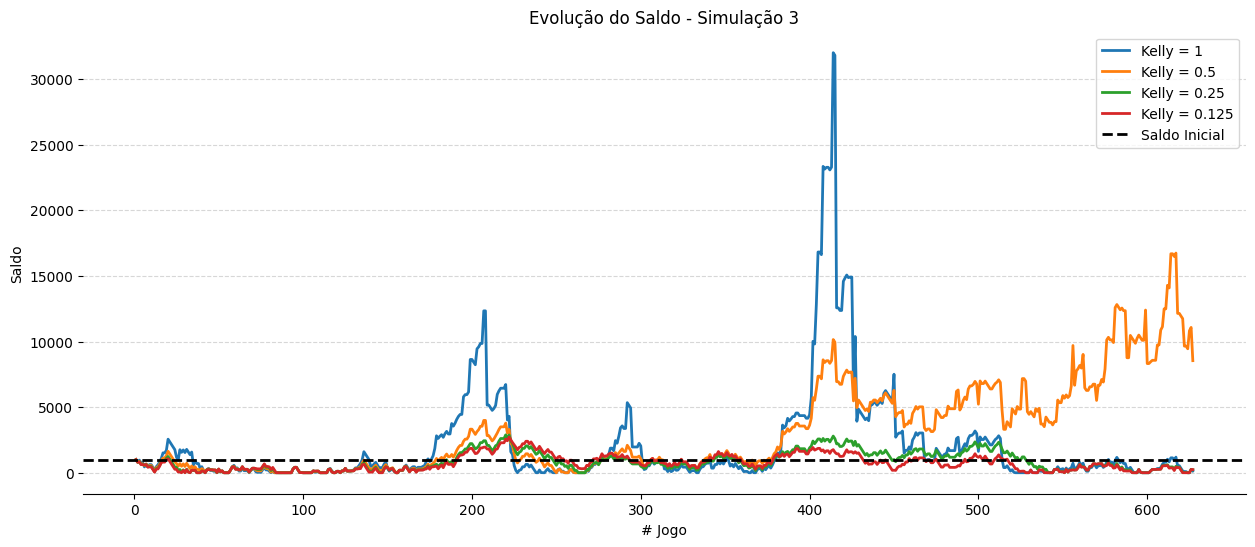

,valor_total_apostado,%_jogos_apostados,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi
0,262591.45,81.5,19248.79,49.71,8724.48,1.000,136.71,-86.33
1,219726.86,81.5,4598.29,51.66,3096.27,0.500,8542.42,754.24
2,88034.26,81.5,452.41,51.27,383.64,0.250,223.18,-77.68
3,76464.35,81.5,213.52,51.47,298.00,0.125,237.59,-76.24


In [588]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas = [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll if f_star_w > 0 else 0

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
        stake_l = f_star_l*bankroll if f_star_l > 0 else 0

        if (1/odds_w) <= 0.4:
            if (1/odds_l) <= 0.43:
                stake_w = 0
                stake_l = 0
                stake = 0 
                flag_aposta = 0
            else:
                stake_w = 0
                stake_l = 200
                stake = stake_l
                flag_aposta = 1
        elif (1/odds_w) > 0.4:
            if  prob_w <=0.79:                
                stake_w = 200
                stake = stake_w
                stake_l = 0
                flag_aposta = 1
            else:
                # stake_w = np.min([stake_w,200])
                stake = stake_w
                stake_l = 0
                flag_aposta = 1
        else:
            stake_w = 0
            stake_l = 0
            stake = 0 
            flag_aposta = 0        
                    
        # stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta        

        if outcome == 1 and stake_w > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value    

        elif outcome == -1 and stake_l > 0:
            aposta_ganha = 1
            win_value = stake * (odds_l - 1)
            lucros.append(win_value)
            bankroll += stake + win_value   
                 
        else:
            aposta_ganha = 0
            lucros.append(-stake)   

        bankroll = np.max([0,bankroll])
       
        stakes.append(stake)        
        apostas.append(flag_aposta)
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll) 

    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)    
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)   

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 3')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

In [586]:
def betting_simulation(B0, Pmin=None, Ltw=None, Utw=None, Ltl=None, Utl=None, kelly_fractions = [1, 0.5, 0.25, 0.125], max_bet_value=None, plot=True):
    """Simula uma estratégia de apostas em um conjunto de dados fornecido.

    Argumentos:    
    B0 (float): Saldo inicial.    
    Pmin (float): Probabilidade predita mínima para uma aposta.
    Ltw (float): Diferença mínima entre probabilidades preditas de vitoria e implícitas de vitoria.
    Ut (float): Diferença máxima entre probabilidades preditas de vitoria e implícitas de vitoria.
    Ltl (float): Diferença mínima entre probabilidades preditas de derrota e implícitas de vitoria.
    Utl (float): Diferença máxima entre probabilidades preditas de derrota e implícitas de vitoria.
    kelly_fractions (lista): Lista de parametros para fração Kelly.
    max_bet_value (float): Aplica um valor teto para as apostas.
    plot (bool): Escolhe se Plota ou nao um grafico da evolução do Saldo.
    """ 
    if plot:
        plt.figure(figsize=(15, 6))    


    Pmin = 0 if Pmin is None else Pmin
    Ltw = -1 if Ltw is None else Ltw # Limite inferior para Vitoria é o menor possível (0 - 1 = -1 ou -1 - 0 = -1)
    Utw = 1 if Utw is None else Utw # Limite superior para Vitoria é o maior possível (1 - 0 = 1 ou 0 - (-1) = 1)     
    Ltl = -1 if Ltl is None else Ltl # Limite inferior para Vitoria é o menor possível (0 - 1 = -1 ou -1 - 0 = -1)
    Utl = 1 if Utl is None else Utl # Limite superior para Vitoria é o maior possível (1 - 0 = 1 ou 0 - (-1) = 1)     

    dfs_resumo = []
    for k in kelly_fractions:

        bankroll = B0 
        bankroll_history = [bankroll]
        stakes, apostas_ganhas, lucros = [], [], []        

        for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):            
            # Verifica se a diferença da probabilidade do modelo (vitoria) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (vitoria) é maior que uma probabilidade minima para se apostar.                     

            diff_prob_impl_homewin = prob_w - (1/odds_w) # Prob Modelo - Prob Implicita Vitoria
            diff_prob_impl_awaywin = prob_l - (1/odds_l) # Prob Modelo - Prob Implicita Derrota

            # print(f'Pmin: {Pmin}')
            # print(f'Lt: {Lt}')
            # print(f'Ut: {Ut}')
            # print(f'ProbW: {prob_w}')
            # print(f'Diff Prob Home: {diff_prob_impl_homewin}')
            # print(f'ProbL: {prob_l}')
            # print(f'Diff Prob Home: {diff_prob_impl_awaywin}')
            
            if Ltw <= (diff_prob_impl_homewin) <= Utw and prob_w >= Pmin:       
                # print('cond1')          

                f_star = kelly_criterion_fraction(prob_w, odds_w, k) # Calcula Kelly
                stake = round(f_star*bankroll,2) # Valor apostado   

                aposta = None 

                if stake < 0:                   
                    # print('stake negativo 1') 
                    stake = 0 # Nao aposta
                    # stake = stake                    

                elif max_bet_value is not None:
                    stake = np.min([stake, max_bet_value]) # Aplica teto  
                    aposta = 1
                
                else:
                    stake = stake
                    aposta = 1

                bankroll -= stake # Retira o valor da aposta do saldo

                if outcome == 1 and stake > 0 and aposta is not None:
                    aposta_ganha = 1
                    win_value = round(stake * (odds_l - 1) ,2)
                    lucros.append(win_value)                    
                    bankroll += stake + win_value # Atualiza o saldo com o valor ganho e aposta

                elif aposta is not None:
                    aposta_ganha = 0
                    # bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            # Verifica se a diferença da probabilidade do modelo (derrota) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (derrota) é maior que uma probabilidade minima para se apostar.
            elif Ltl <= (diff_prob_impl_awaywin) <= Utl and prob_l >= Pmin and aposta is None:
                # print('cond2')   
                
                f_star = kelly_criterion_fraction(prob_l, odds_l, k) # Calcula Kelly
                stake = round(f_star*bankroll,2) # Valor apostado

                if stake < 0:
                    # print('stake negativo 2')
                    stake = 0 # Nao aposta      
                    aposta = 0              

                elif max_bet_value is not None:
                    stake = np.min([stake, max_bet_value]) # Aplica teto   
                    aposta = 1

                else:
                    stake = stake
                    aposta = 1

                bankroll -= stake # Retira o valor da aposta do saldo

                if outcome == -1 and stake > 0 and aposta is not None:
                    aposta_ganha = 1
                    win_value = round(stake * (odds_l - 1),2)
                    lucros.append(win_value)  
                    bankroll += stake + win_value

                elif aposta is not None:
                    aposta_ganha = 0
                    # bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            else: 
                # print('cond3')                  
                stake = 0
                aposta = 0 
                aposta_ganha = 0                
                lucros.append(stake)

            bankroll = round(np.max([0,bankroll]),2) # Se ficar negativo, zera.
            
            stakes.append(stake)
            apostas_ganhas.append(aposta_ganha)
            bankroll_history.append(bankroll)

        print(f'Apostas: {stakes}')
        print(f'Lucros : {lucros}')
        print(f'bankroll: {bankroll_history}')
        
        print(f'Lucro total (k = {k}): {np.sum(lucros)}')
        valor_total_apostado = np.sum(stakes) 
        max_valor_apostado = np.max(stakes)
        max_valor_ganho = np.max(lucros)
        roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
        num_jogo = range(1, len(bankroll_history) + 1)
        qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
        qtd_apostas_ganhas = np.sum(apostas_ganhas)
        print(f'QTD APOST: {qtd_jogos_apostados}')
        print(f'Len bankroll history: {len(bankroll_history)}')
        print(f'QTD APOSTA GANHA: {qtd_apostas_ganhas}')

        df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
        })

        dfs_resumo.append(df_k)

        if plot:
            plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')
    if plot:
        plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

        # Customize plot
        plt.xlabel('# Jogo')
        plt.ylabel('Saldo')
        plt.title('Evolução do Saldo')        
        sns.despine(left=True)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)

        # Show the plot
        plt.show()

    df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)    

    return df_comparacao_k

Apostas: [145.36, 356.14, 0, 739.12, 947.37, 749.78, 1021.17, 1682.78, 7281.75, 11052.99, 0, 779.2, 8116.93, 27382.62, 79568.42, 176637.1, 437793.46, 252734.08, 765570.19, 764723.93, 0, 1896273.65, 0, 426936.72, 158290.05, 453591.92, 694832.57, 323993.77, 1290586.75, 455936.77, 372604.53, 73838.93, 560129.5, 2284232.21, 919620.58, 2770980.69, 654141.04, 1808649.34, 613552.8, 2894307.42, 191002.89, 643730.99, 1974259.69, 5272874.8, 3330884.09, 886015.13, 416162.36, 121725.5, 487535.76, 390861.39, 132656.95, 0, 1580660.34, 11732848.95, 29981772.32, 6046464.25, 16994237.29, 45930900.47, 175209779.3, 22595838.85, 155105489.39, 13862966.86, 73345280.7, 0, 34405234.93, 130141188.46, 157633120.68, 16603454.03, 35492672.7, 0, 242570434.12, 47317049.22, 4065787.59, 19867054.18, 9163520.29, 12875823.62, 12097265.21, 7811056.53, 73714730.97, 25995142.15, 16617309.28, 0, 11039953.22, 42031301.41, 39620691.07, 9691520.15, 3692385.1, 1169904.2, 1892120.2, 2693826.55, 58063.57, 690891.84, 0, 418397.4

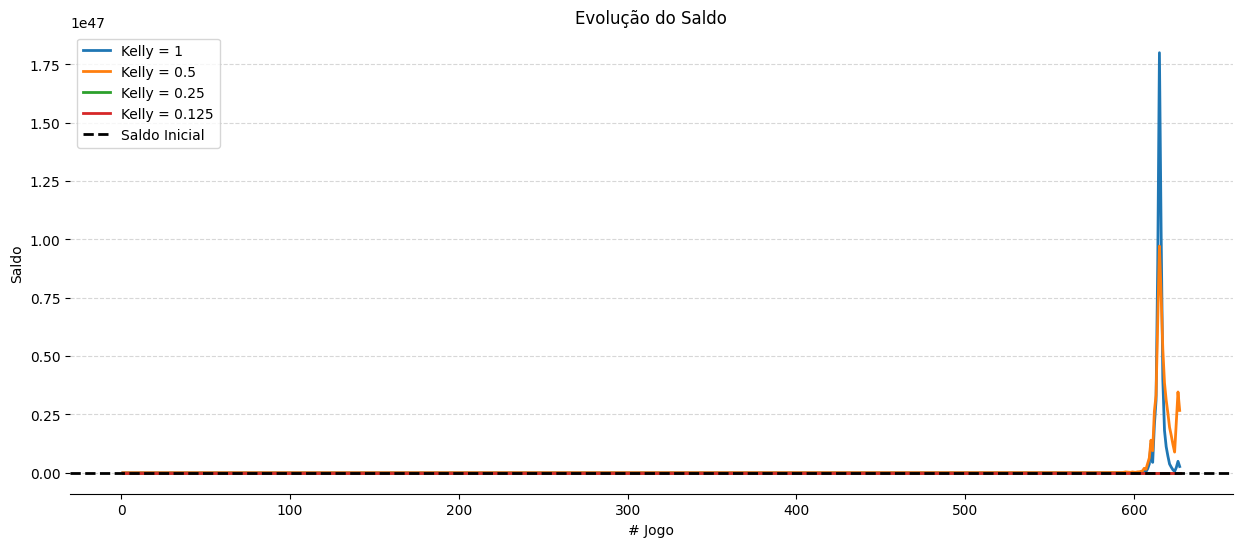

,valor_total_apostado,%_jogos_apostados,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi
0,2.684067e+47,94.74,7.636958e+46,49.16,9.031928e+46,1.000,2.652287e+45,2.652287e+44
1,1.467253e+47,94.74,2.346402e+46,49.16,3.252853e+46,0.500,2.669244e+46,2.669244e+45
2,1.371424e+33,94.74,1.439776e+32,49.16,2.692282e+32,0.250,6.833347e+32,6.833347e+31
3,8.484529e+20,94.74,5.939153e+19,49.16,1.724760e+20,0.125,7.041739e+20,7.041739e+19


In [587]:
df_comparacao_k = betting_simulation(1000,
                                     Pmin=0,
                                     Ltw=-1,
                                     Utw=1,
                                     Ltl=-1,
                                     Utl=1,
                                     kelly_fractions = [1, 0.5, 0.25, 0.125],
                                     max_bet_value=None,
                                     plot=True)
df_comparacao_k

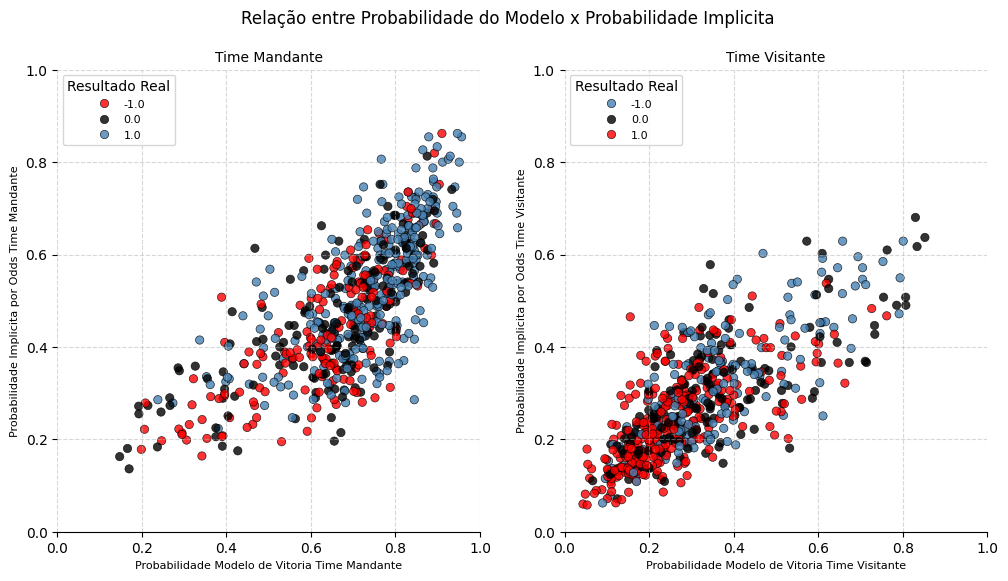

In [457]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# G1
sns.scatterplot(data=df_test_f, 
                x='pred_vitoria', 
                y='prob_impl_vitoria',
                hue='vitoria_man', 
                ax=axs[0],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])

axs[0].set_xlabel('Probabilidade Modelo de Vitoria Time Mandante', fontsize=8)
axs[0].set_ylabel('Probabilidade Implicita por Odds Time Mandante', fontsize=8)
axs[0].set_title('Time Mandante', fontsize=10)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[0].legend(title='Resultado Real', loc='upper left', fontsize=8)

# G2
sns.scatterplot(data=df_test_f, 
                x='pred_derrota', 
                y='prob_impl_derrota',
                hue='vitoria_man', 
                ax=axs[1],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['steelblue','black', 'red'])

axs[1].set_xlabel('Probabilidade Modelo de Vitoria Time Visitante', fontsize=8)
axs[1].set_ylabel('Probabilidade Implicita por Odds Time Visitante', fontsize=8)
axs[1].set_title('Time Visitante', fontsize=10)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[1].legend(title='Resultado Real', loc='upper left', fontsize=8)

fig.suptitle('Relação entre Probabilidade do Modelo x Probabilidade Implicita', fontsize=12)

sns.despine(left=True)

plt.show()

Ao analisar as relações entre as probabilidades, podemos concluir que:
-   Para time mandante, uma Prob. Modelo > 0.5 e Prob. Implicita > 0.6 conseguiria segmentar bem os casos de **vitoria mandante**.
-   Em contrapartida, para o time visitante, uma Prob. Modelo < 0.45 e Prob. Implicita < 0.3 separa bem os casos de **vitoria mandante**.

-   Para time mandante, uma Prob. Modelo < 0.4 e Prob. Implicita < 0.4 conseguiria segmentar bem os casos de **vitoria visitante**.
-   Para time visitante, uma Prob. Modelo > 0.75 e Prob. Implicita > 0.5 conseguiria segmentar bem os casos de **vitoria visitante**.

In [458]:
df_test_f['diff_prob_vitoria'] = df_test_f['pred_vitoria'] - df_test_f['prob_impl_vitoria']
df_test_f['diff_prob_derrota'] = df_test_f['pred_derrota'] - df_test_f['prob_impl_derrota']

df_train_f['diff_prob_vitoria'] = df_train_f['pred_vitoria'] - df_train_f['prob_impl_vitoria']
df_train_f['diff_prob_derrota'] = df_train_f['pred_derrota'] - df_train_f['prob_impl_derrota']

In [779]:
y.astype(str).unique()

array(['1.0', '-1.0', '0.0'], dtype=object)

Optimal threshold: 0.7548270523548126


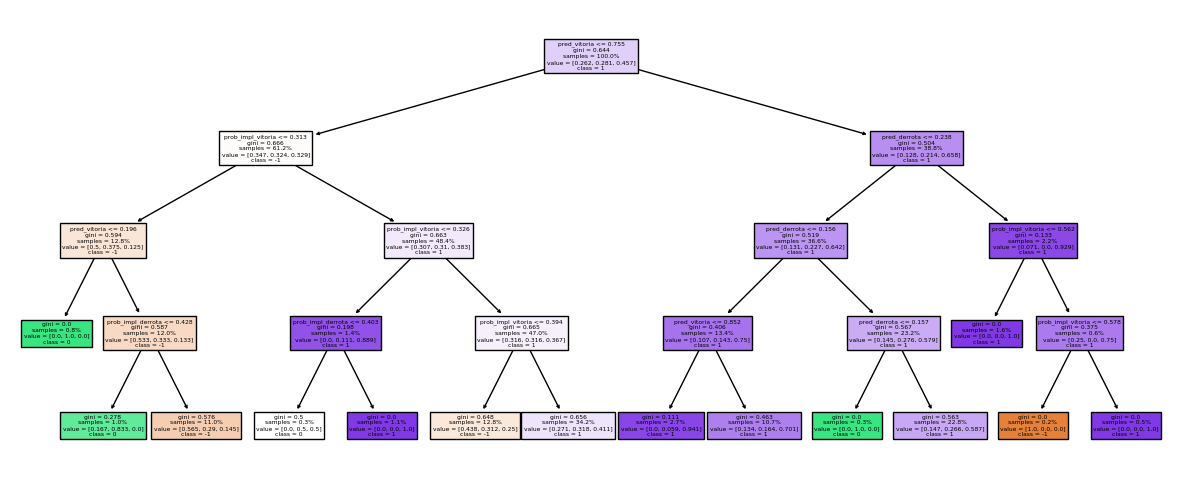

In [475]:
from sklearn import tree
# import graphviz

# Separate features and target
X = df_test_f[['pred_vitoria', 'prob_impl_vitoria', 'pred_derrota', 'prob_impl_derrota']]
y = df_test_f['vitoria_man']

# Create a decision tree with a limited depth
treemodel = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)
treemodel.fit(X, y)

# Extract the optimal threshold
optimal_threshold = treemodel.tree_.threshold[0]
print("Optimal threshold:", optimal_threshold)

plt.figure(figsize=(15, 6))  # Adjust figure size as needed
tree.plot_tree(treemodel, filled=True, feature_names=X.columns, proportion=True, class_names=['-1','0','1'])
plt.show()

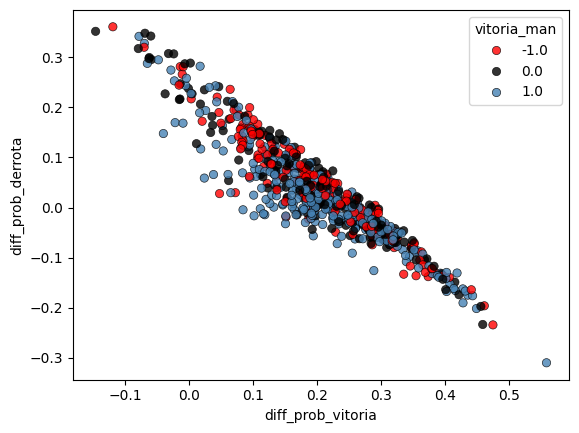

In [478]:
sns.scatterplot(data=df_test_f, 
                x='diff_prob_vitoria', 
                y='diff_prob_derrota',
                hue='vitoria_man',                 
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.show()

Primeira Simulação

Lucro total (k = 1): -999.9999999999916
Lucro total (k = 0.5): -997.4985837154572
Lucro total (k = 0.25): -521.8661348456203
Lucro total (k = 0.125): 228.23974184991653


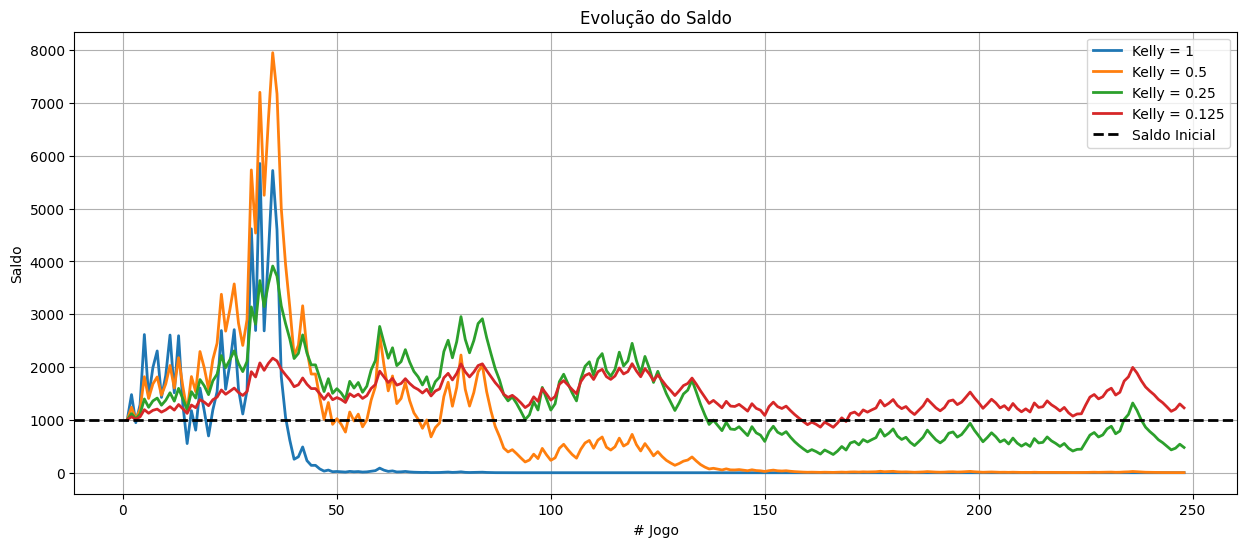

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,38972.86,99.19,47.56,1.000,0.00,-100.00
1,48794.91,99.19,47.56,0.500,2.50,-99.75
2,40196.13,99.19,47.56,0.250,478.13,-52.19
3,21803.70,99.19,47.56,0.125,1228.24,22.82


In [187]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
# odds = 1.8
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros = [], [], []    
    for prob, odds, outcome in zip(preds_prob_w, odds_homewin, y_true):
        
        f_star = kelly_criterion_fraction(prob, odds, k)       
        stake = f_star*bankroll

        if stake < 0:
            stake = 0

        if outcome == 1:
            # winning = 1
            win_value = stake * (odds - 1)
            lucros.append(win_value)
            bankroll += win_value
        else:
            # winning = 0
            bankroll -= stake
            lucros.append(-stake)
        
        aposta_ganha = (1 if stake*outcome>0 else 0)
        
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    # print(stakes)
    print(f'Lucro total (k = {k}): {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes) 
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({'total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
    })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

# Customize plot
plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

In [98]:
df_test_f['AvgH'] = df_test['AvgH']
df_test_f['AvgA'] = df_test['AvgA']

preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = (1 - df_test_f['pred_vitoria']).values
y_true = df_test_f['vitoria'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values

In [ ]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
# odds = 1.8
dfs_resumo = []

In [188]:
def betting_simulation(B0, Pmin, Lt, Ut, kelly_fractions = [1, 0.5, 0.25, 0.125], plot=True):
    """Simula uma estratégia de apostas em um conjunto de dados fornecido.

    Argumentos:    
    B0 (float): Saldo inicial.    
    Pmin (float): Probabilidade predita mínima para uma aposta.
    Lt (float): Diferença mínima entre probabilidades preditas e implícitas.
    Ut (float): Diferença máxima entre probabilidades preditas e implícitas.
    kelly_fractions (lista): Lista de parametros para fração Kelly.
    plot (bool): Escolhe se Plota ou nao um grafico da evolução do Saldo.
    """ 
    if plot:
        plt.figure(figsize=(15, 6))

    dfs_resumo = []
    for k in kelly_fractions:
        bankroll = B0 
        bankroll_history = [bankroll]
        stakes, apostas_ganhas, lucros = [], [], []

        for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
            # Verifica se a diferença da probabilidade do modelo (vitoria) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (vitoria) é maior que uma probabilidade minima para se apostar.
            if Lt < (prob_w - 1 / odds_w) < Ut and prob_w > Pmin: 
                f_star = kelly_criterion_fraction(prob_w, odds_w, k) # Calcula Kelly
                stake = f_star*bankroll # Valor apostado                
                bankroll -= stake # Retira o valor da aposta do saldo
                if outcome == 1:
                    aposta_ganha = 1
                    win_value = stake * (odds_w - 1)
                    lucros.append(win_value)                    
                    bankroll += stake + win_value # Atualiza o saldo com o valor ganho e aposta
                else:
                    aposta_ganha = 0
                    bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            # Verifica se a diferença da probabilidade do modelo (derrota) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (derrota) é maior que uma probabilidade minima para se apostar.
            elif Lt < (prob_l - 1 / odds_l) < Ut and prob_l > Pmin:
                f_star = kelly_criterion_fraction(prob_l, odds_l, k) # Calcula Kelly
                stake = f_star*bankroll # Valor apostado                
                bankroll -= stake # Retira o valor da aposta do saldo
                if outcome == 0:
                    aposta_ganha = 1
                    win_value = stake * (odds_l - 1)
                    lucros.append(win_value)  
                    bankroll += stake + win_value
                else:
                    aposta_ganha = 0
                    bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            stakes.append(stake)
            apostas_ganhas.append(aposta_ganha)
            bankroll_history.append(bankroll)

        print(f'Lucro total (k = {k}): {np.sum(lucros)}')
        valor_total_apostado = np.sum(stakes) 
        roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
        num_jogo = range(1, len(bankroll_history) + 1)
        qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
        qtd_apostas_ganhas = np.sum(apostas_ganhas)

        df_k = pd.DataFrame({'total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
        })

        dfs_resumo.append(df_k)

        if plot:
            plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')
    if plot:
        plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

        # Customize plot
        plt.xlabel('# Jogo')
        plt.ylabel('Saldo')
        plt.title('Evolução do Saldo')        
        sns.despine(left=True)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)

        # Show the plot
        plt.show()

    df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)    

    return df_comparacao_k

Lucro total (k = 1): 160.65370982693082
Lucro total (k = 0.5): 503.5346628808053
Lucro total (k = 0.25): 642.125478225341
Lucro total (k = 0.125): 443.97318726097166


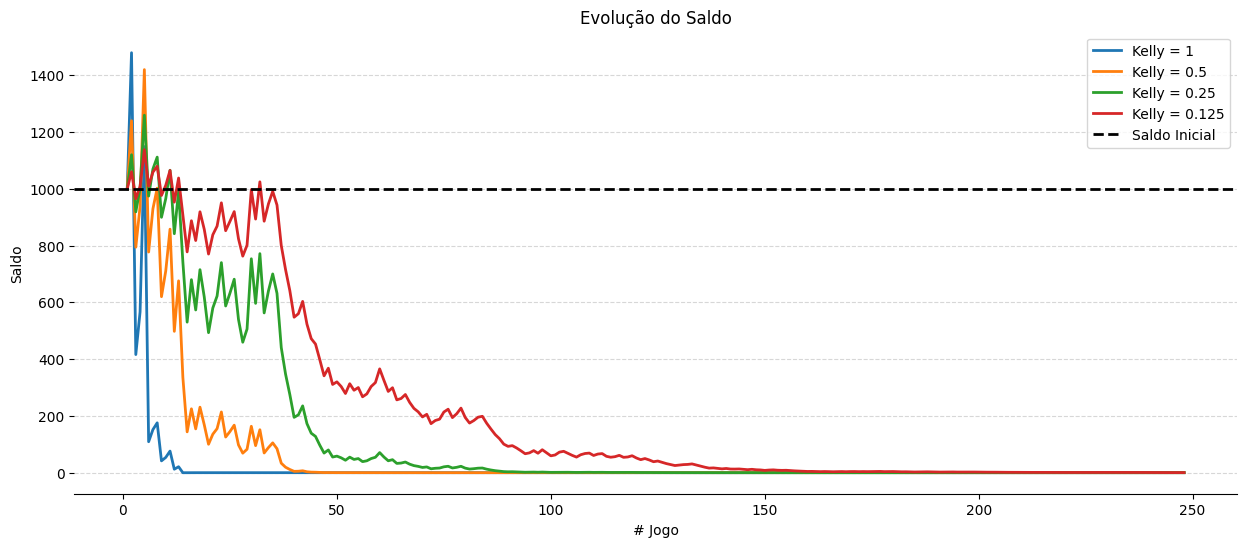

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,2554.93,59.27,79.59,1.000,0.00,-100.00
1,3564.71,99.60,47.37,0.500,0.00,-100.00
2,3763.46,99.60,47.37,0.250,0.00,-100.00
3,3176.96,99.60,47.37,0.125,0.34,-99.97


In [189]:
df_estrategia1 = betting_simulation(B0=1000,Pmin=0, Lt=0, Ut=1)
df_estrategia1

Lucro total (k = 1): 160.65370982691104
Lucro total (k = 0.5): 503.54148354141086
Lucro total (k = 0.25): 644.6848424739309
Lucro total (k = 0.125): 450.1148789299265


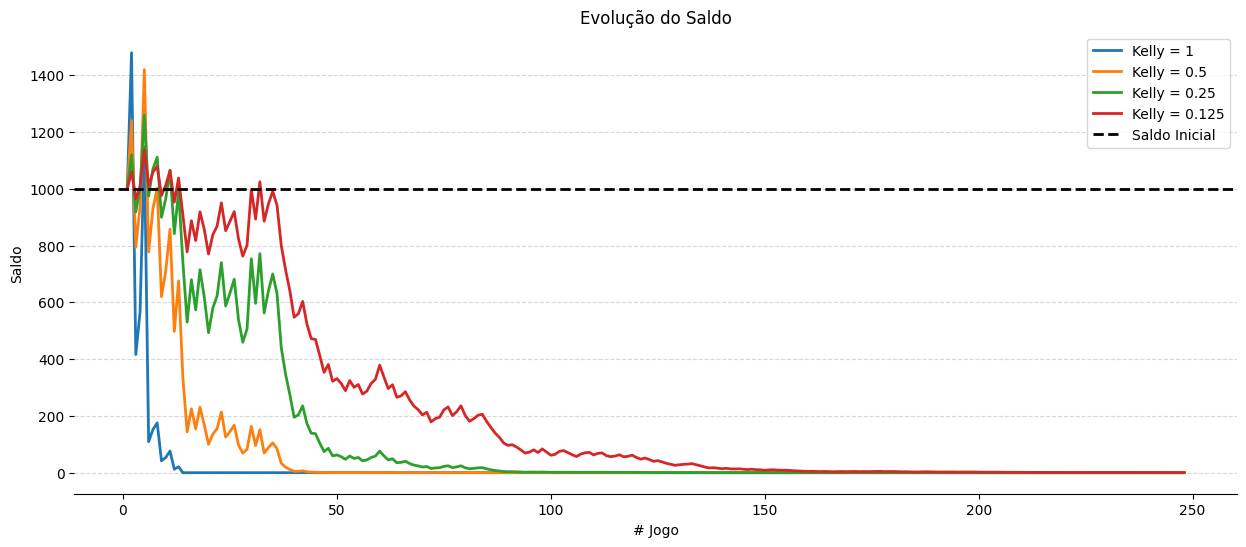

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,2554.93,58.87,80.82,1.000,0.00,-100.00
1,3564.58,99.19,47.97,0.500,0.00,-100.00
2,3765.53,99.19,47.97,0.250,0.00,-100.00
3,3185.69,99.19,47.97,0.125,0.35,-99.96


In [208]:
df_estrategia2 = betting_simulation(B0=1000,Pmin=0.3, Lt=-1, Ut=1)
df_estrategia2

Lucro total (k = 1): -158.1993714325844
Lucro total (k = 0.5): -42.4019089273915
Lucro total (k = 0.25): -13.187405627621978
Lucro total (k = 0.125): -56.97732253522164


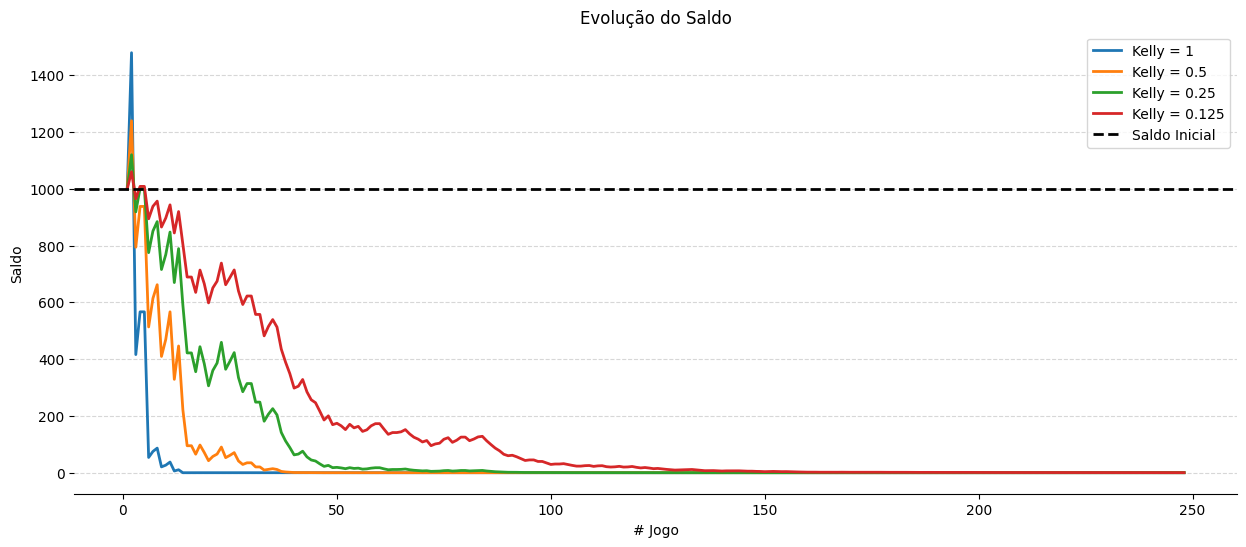

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,1979.13,61.69,75.16,1.000,-0.0,-100.00
1,2424.46,99.60,46.56,0.500,0.0,-100.00
2,2421.37,99.60,46.56,0.250,0.0,-100.00
3,2178.37,99.60,46.56,0.125,0.2,-99.98


In [171]:
df_estrategia3 = betting_simulation(B0=1000,Pmin=0, Lt=0, Ut=0.4)
df_estrategia3